In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops, hash_dict
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [3]:
from sophius.estimate import LSTMRegressor

estimator = torch.load('../data/models/estimator_v1.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

In [19]:
def read_model_db(model_id):    
    with sqlite3.connect('../data/models.db') as conn:
        hash_str = conn.execute(f'SELECT hash FROM models WHERE id==?', (model_id, )).fetchone()[0]
    return encoder.hash2model(hash_str, (3, 32, 32), 10)

read_model_db(2604)

Conv2d       (192, 16, 16)  (5, 5)   (2, 2)  
ReLU         (192, 16, 16) 
MaxPool2d    (192, 16, 16)  (3, 3)   (1, 1)  
BatchNorm2d  (192, 16, 16) 
AvgPool2d    (192, 9, 9)    (2, 2)   (2, 2)  
Conv2d       (64, 9, 9)     (3, 3)   (1, 1)  
PReLU        (64, 9, 9)    
BatchNorm2d  (64, 9, 9)    
AvgPool2d    (64, 8, 8)     (2, 2)   (1, 1)  
Conv2d       (192, 2, 2)    (7, 7)   (4, 4)  
ReLU         (192, 2, 2)   
BatchNorm2d  (192, 2, 2)   
PReLU        (192, 2, 2)   
BatchNorm2d  (192, 2, 2)   
GlobalAvgPool2d (192, 1, 1)   
Flatten      192           
Linear       10            

Conv2d       (16, 7, 7)     (5, 5)   (4, 4)  
ReLU         (16, 7, 7)    
MaxPool2d    (16, 2, 2)     (2, 2)   (3, 3)  
GlobalAvgPool2d (16, 1, 1)    
Flatten      16            
Linear       10            



Loss 307.853: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


val_acc: 0.257 train_acc: 0.276
val_acc* 0.334


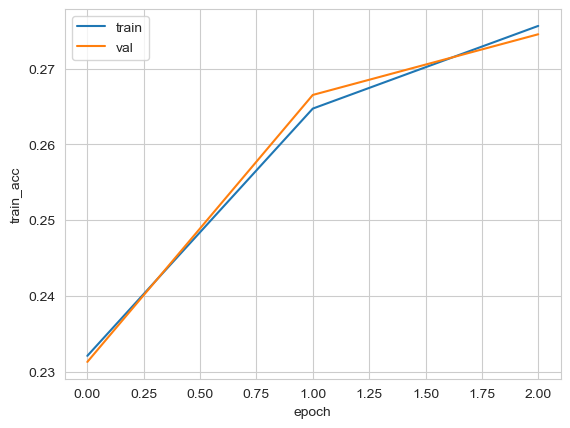

In [22]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=3, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
# model_tmpl = read_model_db(2604)

model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)

print(model_tmpl)

val_acc_threshold = 0.6

train_params = {
    'val_size': 10000,
    'batch_size': 256,
    'num_epoch': 3,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [23]:
import sqlite3
from sophius.utils import hash_dict

exp_id = 0
with sqlite3.connect('../data/models.db') as conn:
    try:
        exp_id = conn.execute('SELECT COUNT(*) FROM test_experiments').fetchone()[0]
    except:
        pass
    exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}
    
    df = pd.DataFrame([exp_params], index=[exp_id])
    df.index.name = 'id'
    exp_hash = hash_dict(exp_params)
    df['hash'] = exp_hash
    # cast complex objects to string
    for col in ['opt_params', 'sch_params', 'in_shape', 'out_shape']:
        df[col] = df[col].astype(str)
    
    if exp_id == 0:
        print('Creating new experiment')
        df.to_sql('test_experiments', conn, if_exists='append')
    else:
        # check if experiment exists
        res = conn.execute('SELECT id FROM test_experiments WHERE hash == ?', (exp_hash,)).fetchone()
        if res:
            print('Experiment exists')
            print(exp_params)
            exp_id = res[0]
        else:
            print('Creating new experiment')
            print(exp_params)
            df.to_sql('test_experiments', conn, if_exists='append')    
exp_id

Creating new experiment
{'val_size': 10000, 'batch_size': 256, 'num_epoch': 3, 'random_seed': 42, 'optimizer': 'AdamW', 'opt_params': {'lr': 0.001}, 'scheduler': 'ExponentialLR', 'sch_params': {'gamma': 0.95}, 'in_shape': (3, 32, 32), 'out_shape': 10}


1

In [13]:
# run stats - run_id, run params
# run_models run_id -> model_id 
# model stats model_id, hash, flops, batch_size
# model_per_epoch stats model_id, 

In [25]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=3, lin_num=1)
estimator = torch.load('../data/models/estimator_v1.pth').cpu()
val_acc_threshold = 0.6

for i in tqdm(range(10)):
    model_tmpl = model_gen.generate_model_tmpl()    
    model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
    
    est_val_acc = estimate_acc(model_tmpl) 
    if est_val_acc < val_acc_threshold:
        print('Skip estimated', est_val_acc)
        continue
    
    epoch_results = train_on_gpu_ex(
        model=model,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    model_id = 0
    with sqlite3.connect('../data/models.db') as conn:
        try:
            model_id = conn.execute('SELECT COUNT(*) FROM test_models').fetchone()[0]
        except:
            pass
        
    model_results = calc_model_flops(model, (3, 32, 32))
    model_results['id'] = model_id
    model_results['exp_id'] = exp_id
    model_results['hash'] = encoder.model2hash(model_tmpl)    
    model_results['val_acc'] = epoch_results.val_acc.iloc[-10:].mean()
    model_results['train_acc'] = epoch_results.train_acc.iloc[-10:].mean()
    model_results['time'] = epoch_results.time.iloc[-1]
    
    epoch_results['model_id'] = model_id
    epoch_results['exp_id'] = exp_id

    with sqlite3.connect('../data/models.db') as conn:
        df = pd.DataFrame([model_results]).set_index('id') 
        df.to_sql('test_models', conn, if_exists='append')
        
        epoch_results.to_sql('test_model_epochs', conn, if_exists='append', index=False)
        
#     # print(df.loc[i])

  0%|          | 0/10 [00:00<?, ?it/s]

Skip estimated 0.3099738359451294
Skip estimated 0.5542863607406616


 30%|███       | 3/10 [00:03<00:08,  1.17s/it]

Skip estimated 0.507366955280304
Skip estimated 0.46121448278427124
Skip estimated 0.3024592101573944


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

Skip estimated 0.2615108788013458
Skip estimated 0.5626733303070068
